<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A4-Neural-Network-Classifier" data-toc-modified-id="A4-Neural-Network-Classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A4 Neural Network Classifier</a></span><ul class="toc-item"><li><span><a href="#NeuralNetworkClassifier" data-toc-modified-id="NeuralNetworkClassifier-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><code>NeuralNetworkClassifier</code></a></span></li><li><span><a href="#percent_correct" data-toc-modified-id="percent_correct-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><code>percent_correct</code></a></span></li><li><span><a href="#Apply-NeuralNetworkClassifier-to-Images-of-Handwritten-Digits" data-toc-modified-id="Apply-NeuralNetworkClassifier-to-Images-of-Handwritten-Digits-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Apply <code>NeuralNetworkClassifier</code> to Images of Handwritten Digits</a></span></li><li><span><a href="#Define-train_for_best_validation-and-apply-to-MNIST-data" data-toc-modified-id="Define-train_for_best_validation-and-apply-to-MNIST-data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Define <code>train_for_best_validation</code> and apply to MNIST data</a></span></li></ul></li><li><span><a href="#Grading" data-toc-modified-id="Grading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

# A4 Neural Network Classifier

## `NeuralNetworkClassifier`

Starting with the `NeuralNetwork` class defined in Lecture Notes 12, complete the subclass `NeuralNetworkClassifier` as discussed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optimizers as opt
import sys

In [2]:
class NeuralNetwork():

    def __init__(self, n_inputs, n_hiddens_list, n_outputs):

        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        self.n_layers = len(n_hiddens_list) + 1

        self.all_weights, self.Ws = self.make_weights()
        self.initialize_weights()
        self.all_gradients, self.Gs = self.make_weights()

        self.stand_params = None
        self.error_trace = []

    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs})'

    def make_weights(self):
        # Create list of matrix shapes, one per layer
        n_in = self.n_inputs
        units = self.n_hiddens_list + [self.n_outputs]
        shapes = []
        for n_units in units:
            shapes.append((n_in + 1, n_units))
            n_in = n_units

        # Allocate contiguous memory to hold all weights
        n_weights = sum([ni * nu for (ni, nu) in shapes])
        all_weights = np.zeros(n_weights)

        # Create numpy views into this memory with the appropriate
        # shapes to be our weight matrices.
        Ws = []
        first = 0
        for (ni, nu) in shapes:
            n_w = ni * nu
            W = all_weights[first:first + n_w].reshape(ni, nu)
            Ws.append(W)
            first += n_w

        return all_weights, Ws

    def initialize_weights(self):
        for W in self.Ws:
            ni, nu = W.shape
            W[:] = np.random.uniform(-1, 1, size=(ni, nu)) / np.sqrt(ni)
        self.error_trace = []

    def forward(self,Xst):
        Ys = [Xst]
        for layer_i, W in enumerate(self.Ws):
            X = Ys[-1]
            Y = self.add_ones(X) @ W
            if layer_i < self.n_layers - 1:
                Y = np.tanh(Y)
            Ys.append(Y)
        return Ys[1:]  # remove X from Ys

    def backward(self, Xst, Tst):
        n_samples = Xst.shape[0]

        Ys = self.forward(Xst)
        Ys = [Xst] + Ys  # Ys now has n_layers + 1 elements.  Ws still has n_layers elements.
        delta = - (Tst - Ys[-1]) / (n_samples * self.n_outputs)
        for layeri in range(self.n_layers)[::-1]:
            X = Ys[layeri]
            self.Gs[layeri][:] = self.add_ones(X).T @ delta
            if layeri > 0:
                delta = delta @ self.Ws[layeri][1:, :].T
                Y = X  # Ys[layeri]
                delta *= 1 - Ys[layeri] ** 2
            # if layeri < self.n_layers - 1:
            #     delta *= 1 - Y ** 2
        # print(self.all_gradients)
        return self.all_gradients

    def mse(self, Xst, Tst):
        Yst = self.forward(Xst)
        return 0.5 * np.mean((Tst - Yst[-1])**2)

    def train(self, X, T, n_epochs, learning_rate=0.01, method='scg', verbose=True):

        self.stand_params = self.calc_standardize_parameters(X, T)
        Xst = self.standardize_X(X)
        Tst = self.standardize_T(T)

        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        elif method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        elif method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
        else:
            print('train: method must be \'sgd\', \'adam\', or \'scg\'.')

        def error_convert(err):
            if T.shape[1] == 1:
                return np.sqrt(err) * self.stand_params['Tstds']
            else:
                # Can't unstandardize err if more than one network output
                return np.sqrt(err)
            
        error_trace = optimizer(self.mse, self.backward, [Xst, Tst],
                                n_epochs, learning_rate,
                                error_convert_f=error_convert,
                                verbose=verbose)
        self.error_trace += error_trace
        return self

    def use(self, X, return_hidden_layer_outputs=False):
        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        Y = self.unstandardize_T(Y)
        Zs = Ys[:-1]
        return (Y, Zs) if return_hidden_layer_outputs else Y

    def get_error_trace(self):
        return self.error_trace

    def add_ones(self, X):
        return np.insert(X, 0, 1, axis=1)

    def calc_standardize_parameters(self, X, T):
        Xmeans = X.mean(axis=0)
        Xstds = X.std(axis=0)
        Xstds[Xstds == 0] = np.mean(Xstds[Xstds > 0])
        Tmeans = T.mean(axis=0)
        Tstds = T.std(axis=0)
        return {'Xmeans': Xmeans, 'Xstds': Xstds, 'Tmeans': Tmeans, 'Tstds': Tstds}

    def standardize_X(self, X):
        return (X - self.stand_params['Xmeans']) / self.stand_params['Xstds']

    def unstandardize_X(self, Xst):
        return Xst * self.stand_params['Xstds'] + self.stand_params['Xmeans']

    def standardize_T(self, T):
        return (T - self.stand_params['Tmeans']) / self.stand_params['Tstds']

    def unstandardize_T(self, Tst):
        return Tst * self.stand_params['Tstds'] + self.stand_params['Tmeans']

In [91]:
#We have to define a new class that inherits from the base class "Neural Network"
class NeuralNetworkClassifier(NeuralNetwork):     
        
     # Override base class implementation to do nothing
    def _standardizeT(self, T):
        return T
    
    # Override base class implementation to do nothing
    def _unstandardizeT(self, T):
        return T

    def use(self, X, return_hidden_layer_outputs=False):
        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        Y = self._unstandardizeT(Y)
        # Convert Y to 'classes' 
        # argmax returns an index into the class array, not the value
        classes= list(self.argmax(Y,axis=1))
        Zs = Ys[:-1]
        return (classes, Y, Zs) if return_hidden_layer_outputs else (classes, Y)   
        
    def forward(self,X):
        Y, Z = super().forward(X)
        Y = self.softmax(Y)
        return Y, Z 
      
    def _make_indicator_variables(self, T):
        # Make sure T is two-dimensiona. Should be nSamples x 1.
        if T.ndim == 1:
            T = T.reshape((-1,1))    
            return (T == np.unique(T)).astype(int)
        
    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = max(0, np.max(Y))
        expY = np.exp(Y - maxY)
        denom = np.sum(expY, axis=1).reshape((-1, 1)) 
        Y = expY / (denom + sys.float_info.epsilon)             # requires an    import sys
        return Y
    
    def neg_log_likelihood(self, X, T):
        Y = self.forward(X)
        Y = self.softmax(Y[-1])
        log_likelihood = (T * np.log(Y + sys.float_info.epsilon).astype('float'))
        return -np.mean(log_likelihood)
    
    def train(self, X, T, n_epochs, method, learning_rate=0.01, verbose=True):
        #One change is that we are not standardizing our targets. Our targets are going to be integers 
        
        self.stand_params = self.calc_standardize_parameters(X, T)
        Xst = self.standardize_X(X)
        self.classes, counts = np.unique(T, return_counts=True)
        self.most_common_class = self.classes[np.argmax(counts)]

        if self.n_outputs != len(self.classes):
            raise ValueError(f'''In NeuralNetworkClassifier, the number of outputs must equal the number of classes in the training data. The given number of outputs is {self.n_outputs} and number of classes is {len(self.classes)}. Try changing the number of outputs in the call to NeuralNetworkClassifier().''')

        # Convert targets into indicator variables
        T_ind_vars = self._make_indicator_variables(T)
        
#         def error_convert(neg_log_likelihood):
#         if T.shape[1] == 1:
#             return self.sqrt(neg_log_likelihood) * self.stand_params['Tstds']
#         else:
#         # Can't unstandardize err if more than one network output
#             #print(neg_log_likelihood) 
#             return np.sqrt(-neg_log_likelihood)
        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        elif method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        elif method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
        else:
            print('train: method must be \'sgd\', \'adam\', or \'scg\'.')
            
        def error_convert(negLL):
            return -negLL
        
        error_trace = optimizer(self.neg_log_likelihood, self.backward, [Xst, T_ind_vars],
                                     n_epochs, learning_rate,error_convert_f=error_convert,verbose=verbose)
        
        self.error_trace += error_trace
        return self

## `percent_correct`

When trying to classify real data, we need a way to evaluate our performance.  One way is to just calculate the percent of samples correctly classified, and to show a confusion matrix.  Define the function
`percent_correct(Y, T)`, that returns the percent of samples correctly classified, given `T` as a column matrix of class labels, and `Y` as the column matrix of classes predicted by `use`.

In [92]:
#def percent_corect(Y,T):   

In [93]:
X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
T = np.array([[0], [1], [1], [0]])
X, T

(array([[0, 0],
        [1, 0],
        [0, 1],
        [1, 1]]),
 array([[0],
        [1],
        [1],
        [0]]))

In [94]:
np.random.seed(111)
nnet = NeuralNetworkClassifier(2, [10], 2)

In [95]:
nnet.Ws

[array([[ 0.12952296, -0.38212533, -0.07383268,  0.31091752, -0.23633798,
         -0.40511172, -0.55139454, -0.09211682, -0.30174387, -0.18745848],
        [ 0.56662595, -0.3028474 , -0.48359706,  0.19583749,  0.13999926,
         -0.26066957, -0.03900416, -0.44067096, -0.49195143,  0.46277416],
        [ 0.33943873,  0.39325596,  0.36397022,  0.56690583,  0.08922813,
          0.36230683, -0.09085429, -0.5456561 , -0.05295844, -0.45573018]]),
 array([[ 0.19129089,  0.11923431],
        [ 0.03936858, -0.13614606],
        [ 0.30059098, -0.21826885],
        [ 0.06959828, -0.00902345],
        [-0.05727085,  0.13739817],
        [-0.10684722, -0.05997329],
        [-0.10916737,  0.26968491],
        [ 0.25249064,  0.18925528],
        [-0.28096209,  0.2673639 ],
        [ 0.27162504,  0.18488136],
        [-0.01128977,  0.2814664 ]])]

In [96]:
#print(nnet.neg_log_likelihood)

If you add some print statements in `neg_log_likelihood` functions, you can compare your output to the following results.

In [97]:
nnet.train(X, T, 1,'sgd', 0.1)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [14]:
np.exp(-0.35674)

0.6999544622383824

Now if you comment out those print statements, you can run for more epochs without tons of output.

In [6]:
np.random.seed(111)
nnet = NeuralNetworkClassifier(2, [10], 2)

In [7]:
nnet.train(X, T, 100, method='scg')

SCG: Epoch 10 Error=0.99066
SCG: Epoch 20 Error=0.99994
SCG: Epoch 30 Error=1.00000


NeuralNetwork(2, [10], 2)

In [8]:
nnet.use(X)

(array([[0],
        [1],
        [1],
        [0]]),
 array([[9.99999987e-01, 1.28250653e-08],
        [1.01010817e-08, 9.99999990e-01],
        [8.80184466e-09, 9.99999991e-01],
        [9.99999979e-01, 2.13188420e-08]]))

In [9]:
percent_correct(nnet.use(X)[0], T)

100.0

Works!  The XOR problem was used early in the history of neural networks as a problem that cannot be solved with a linear model.  Let's try it.  It turns out our neural network code can do this if we use an empty list for the hidden unit structure!

In [7]:
nnet = NeuralNetworkClassifier(2, [], 2)
nnet.train(X, T, 100)   # default method is 'scg'

NeuralNetwork(2, [], 2)

In [8]:
nnet.use(X)

(array([[1],
        [0],
        [1],
        [0]]),
 array([[0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5]]))

In [9]:
percent_correct(nnet.use(X)[0], T)

50.0

A second way to evaluate a classifier is to calculate a confusion matrix. This shows the percent accuracy for each class, and also shows which classes are predicted in error.

Here is a function you can use to show a confusion matrix.

In [10]:
import pandas

def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    # cf.style.background_gradient(cmap='Blues').format("{:.1f} %")
    print('Percent Correct')
    return conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")

In [11]:
confusion_matrix(nnet.use(X)[0], T)

Percent Correct


,0,1
0,50.0,50.0
1,50.0,50.0


## Apply `NeuralNetworkClassifier` to Images of Handwritten Digits

Apply your `NeuralNetworkClassifier` to the [MNIST digits dataset](http://deeplearning.net/tutorial/gettingstarted.html).

In [47]:
import pickle
import gzip

In [13]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


In [14]:
28*28

784

In [15]:
def draw_image(image, label):
    plt.imshow(-image.reshape(28, 28), cmap='gray')
    # plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title(label)

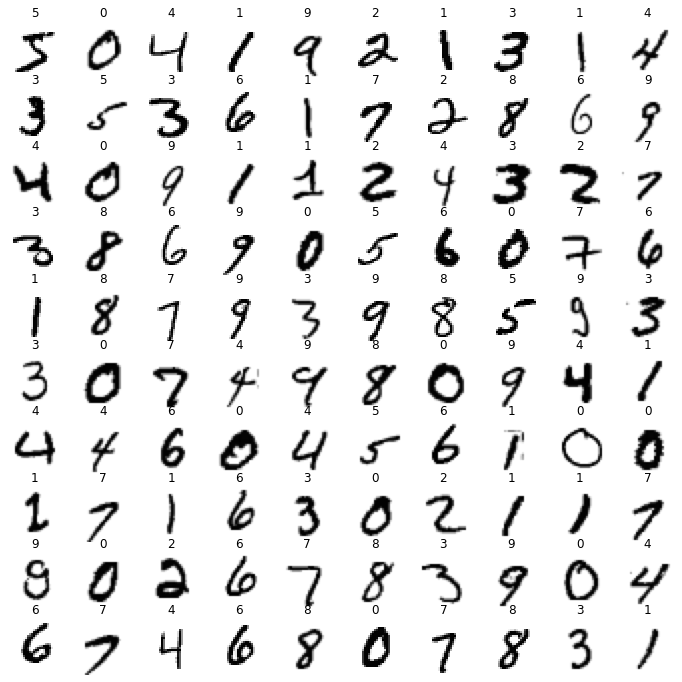

In [16]:
plt.figure(figsize=(12, 12))
for i in range(100):
    plt.subplot(10, 10, i+1)
    draw_image(Xtrain[i], Ttrain[i,0])

In [17]:
nnet = NeuralNetworkClassifier(784, [], 10)
nnet.train(Xtrain, Ttrain, 40)

SCG: Epoch 4 Error=0.95202
SCG: Epoch 8 Error=0.96838
SCG: Epoch 12 Error=0.97241
SCG: Epoch 16 Error=0.97312
SCG: Epoch 20 Error=0.97312
SCG: Epoch 24 Error=0.97312
SCG: Epoch 28 Error=0.97326
SCG: Epoch 32 Error=0.97444
SCG: Epoch 36 Error=0.97531
SCG: Epoch 40 Error=0.97603


NeuralNetwork(784, [], 10)

In [18]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]

[93.362, 92.64, 92.13]

In [19]:
nnet = NeuralNetworkClassifier(784, [20], 10)
nnet.train(Xtrain, Ttrain, 40)

SCG: Epoch 4 Error=0.93705
SCG: Epoch 8 Error=0.96538
SCG: Epoch 12 Error=0.97457
SCG: Epoch 16 Error=0.97976
SCG: Epoch 20 Error=0.98303
SCG: Epoch 24 Error=0.98530
SCG: Epoch 28 Error=0.98699
SCG: Epoch 32 Error=0.98836
SCG: Epoch 36 Error=0.98957
SCG: Epoch 40 Error=0.99070


NeuralNetwork(784, [20], 10)

In [20]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest],
                                                    [Ttrain, Tval, Ttest])]

[97.492, 94.08, 93.33]

## Define `train_for_best_validation` and apply to MNIST data

Using the function `run` from Lecture Notes 11 as a guide, define a new function `train_for_best_validation` that accepts arguments
* `Xtrain, Ttrain`: matrices of shapes $N\times D$ and $N\times 1$ as input and target training data, where $N$ is number of training samples and $D$ is number of input components,
* `Xval, Tval`: matrices of shapes  $N\times D$ and $N\times 1$ of validation data ($N$ not same value as above)
* `n_epochs`: total number of epochs to train for,
* `n_epochs_per_train`: divide `n_epochs` by this value to get number of times the neural network `train` function is called for this many epochs,
* `n_hiddens_list`: structure of hidden layers,
* `method`: optimizer method,
* `learning_rate`: used for optimizer methods 'adam' and 'sgd'.

It must return 
* `nnet`: resulting neural network with weights that produced the highest accuracy for the validation data set,
* `epoch`: epoch corresponding to best validation accuracy,
* `train_accuracy`: accuracy at that best epoch on training data,
* `val_accuracy`: accuracy at that best epoch on validation data.

This function should call your `percent_correct` function to calculate classification accuracies.

Apply it to the MNIST data as shown below.

In [1]:
#Functions: Run(lecture 11),train_for_validation

Epoch 10: Train Accuracy 92.58800000000001 Validation Accuracy 92.73
Epoch 20: Train Accuracy 95.298 Validation Accuracy 94.03
Epoch 30: Train Accuracy 96.382 Validation Accuracy 94.57
Epoch 40: Train Accuracy 97.0 Validation Accuracy 94.59
Epoch 50: Train Accuracy 97.49 Validation Accuracy 94.56
Epoch 60: Train Accuracy 97.868 Validation Accuracy 94.55
Epoch 70: Train Accuracy 98.114 Validation Accuracy 94.53
Epoch 80: Train Accuracy 98.38799999999999 Validation Accuracy 94.36
Epoch 90: Train Accuracy 98.542 Validation Accuracy 94.28999999999999
Epoch 100: Train Accuracy 98.678 Validation Accuracy 94.17
Epoch 110: Train Accuracy 98.804 Validation Accuracy 94.26
Epoch 120: Train Accuracy 98.9 Validation Accuracy 94.1
Epoch 130: Train Accuracy 98.992 Validation Accuracy 94.12
Epoch 140: Train Accuracy 99.084 Validation Accuracy 94.05
Epoch 150: Train Accuracy 99.18 Validation Accuracy 93.96
Epoch 160: Train Accuracy 99.226 Validation Accuracy 93.94
Epoch 170: Train Accuracy 99.298 Valid

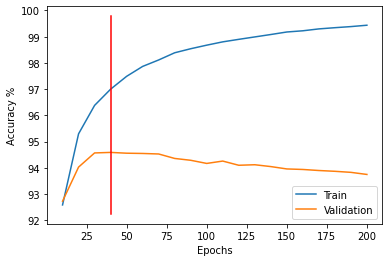

In [21]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 10, [20], method='scg') 

In [22]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]

[97.0, 94.59, 93.74]

Call `train_for_best_validation` a number of times to compare accuracies using the three different optimization methods, and a few different values of `n_epochs`, `n_epochs_per_train`, and `n_hiddens_list`, and `learning_rate` when using 'sgd' and 'adam'.  You do not have to find the very best values of these parameters.  For example, for `n_hiddens_list` at least use `[]` (a linear model) and a larger network, like `[100, 100]`.

Show the confusion matrix for the network that gave you the best validation accuracy.

Write at least 10 sentences about what you observe in the accuracy plots, the train, validation and test accuracies, and the confusion matrix.

# Grading

Download [A4grader.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4grader.tar), extract `A4grader.py` before running the following cell.


======================= Code Execution =======================

Extracting python code from notebook named 'Anderson-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

## Testing constructor ####################################################################

    # Linear network
    nnet = NeuralNetworkClassifier(2, [], 5)
    # Is isinstance(nnet, NeuralNetwork) True?


--- 5/5 points. NeuralNetworkClassifier is correctly of type NeuralNetwork

## Testing constructor ####################################################################

    # Linear network
    nnet = NeuralNetworkClassifier(2, [], 5)
    W_shapes = [W.shape for W in nnet.Ws]


--- 5/5 points. W_shapes is correct value of [(3, 5)]

## Testing constructor ####################################################################

    G_shapes = [G.shape for G in nnet.Gs]


--- 5/5 points. G_shapes is correct value of [(3, 5)]

## Testing train #######

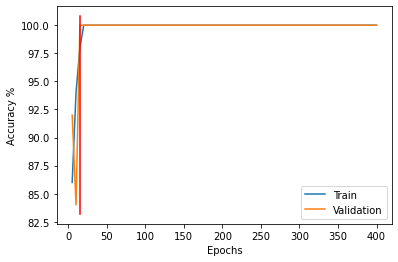

In [30]:
%run -i A4grader.py

# Extra Credit

Repeat the above experiments with a different data set.  Randonly partition your data into training, validaton and test parts if not already provided.  Write in markdown cells descriptions of the data and your results.